In [1]:
%matplotlib notebook
%matplotlib inline

import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

# Setup spark

In [2]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)


In [3]:
spark_session

Hovering over "Spark UI" above gives you the port number of the Spark web dashboard.  Epyc doesn't have that port open, though, so we use an SSH tunnel to forward the ports.  I like to put the following function into my `.bashrc` o my local machine:


```
function spark_tunnel()
{
        # this function takes one argument: the epyc port to tunnel
        # the ordering is backwards (requiring a manual refresh) because
        # I want to be able to manually kill the ssh tunnel
        open http://localhost:${1}/
        ssh -N -L ${1}:127.0.0.1:${1} username@epyc.astro.washington.edu
}
```

What tables does AXS know about?

# Load ZTF data

In [4]:
ztf = catalog.load('ztf_mar19_all')

# Plotting

In [5]:
def plot_lightcurve(row):
    plt.figure(figsize=(8, 6))

    for filterid in np.unique(row['filterid']):
        cut = np.array(row['filterid']) == filterid
        def cc(x):
            return np.array(x)[cut]
        plt.errorbar(cc(np.array(row['mjd'])), cc(row['psfmag']), cc(row['psfmagerr']), fmt='o', c='C%d' % filterid, label='Filter %d' % filterid)

    plt.xlabel('mjd')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.title('matchid %d' % row['matchid'])
    plt.gca().invert_yaxis()

# Dipper detection

In [6]:
from scipy.ndimage import minimum_filter1d

def detect_dippers(mjd, filterid, psfmag, psfmagerr, verbose=False, return_mjd=False):
    if len(mjd) == 0:
        return 0.
    
    order = np.argsort(mjd)
    
    # Throw out repeated measurements.
    ordered_mjd = np.array(mjd)[order]
    mask = np.abs(ordered_mjd - np.roll(ordered_mjd, 1)) > 1e-5
    
    mjd = np.array(mjd)[order][mask]
    filterid = np.array(filterid)[order][mask]
    psfmag = np.array(psfmag)[order][mask]
    psfmagerr = np.array(psfmagerr)[order][mask]

    scores = np.zeros(len(psfmag))

    for iter_filterid in np.unique(filterid):
        cut = filterid == iter_filterid

        if np.sum(cut) < 10:
            # Require at least 10 observations to have reasonable statistics.
            continue

        use_psfmag = psfmag[cut]
        use_psfmagerr = psfmagerr[cut]
        
        # Use the middle 80% of observations to estimate the standard deviation
        # of the observations in a pseudo-NMAD like measurement. I empirically
        # calculated a correction factor assuming a normal distribution.
        median = np.median(use_psfmag)
        core_std = np.percentile(np.abs(use_psfmag - median), 80) / 1.281

        filter_scores = (use_psfmag - median) / np.sqrt(core_std**2 + use_psfmagerr**2)

        scores[cut] = filter_scores
                
    # Check for sequential runs.
    
    # Get the minimum score for a run.
    filtered_scores = minimum_filter1d(scores, 4, mode='constant')
        
    result = float(np.max(filtered_scores))
    max_mjd = mjd[np.argmax(filtered_scores)]

    if verbose:
        print("Max mjd: ", max_mjd)

    if return_mjd:
        return result, max_mjd
    else:
        return result

def detect_dippers_row(row, verbose=False, return_mjd=False):
    return detect_dippers(row['mjd'], row['filterid'], row['psfmag'],
                          row['psfmagerr'], verbose=verbose, return_mjd=return_mjd)

# Create a UDF for spark
detect_dippers_udf = sparkfunc.udf(detect_dippers, returnType=pyspark_types.FloatType())

# Run the spark query

In [7]:
%%time

# Run on spark
res = (
    ztf.region(ra1=290, ra2=291, dec1=25, dec2=26)
    .exclude_duplicates()
    .where(sparkfunc.col("nobs_avail") > 20)
    .select(
        '*',
        detect_dippers_udf(ztf['mjd'], ztf['filterid'], ztf['psfmag'], ztf['psfmagerr']).alias('score')
    )
    .where(sparkfunc.col("score") > 2.)
    .collect()
)
print(len(res))

415
CPU times: user 546 ms, sys: 244 ms, total: 790 ms
Wall time: 17min 42s


# Analysis

In [8]:
# Order the light curves by their scores
scores = []
mjds = []

for i in res:
    score, mjd = detect_dippers_row(i, return_mjd=True)
    scores.append(score)
    mjds.append(mjd)

order = np.argsort(scores)[::-1]

# Apparently things break if you cast a list of spark objects into a numpy array,
# so keep everything as a list.
ordered_res = [res[i] for i in order]

Max mjd:  58338.2745139
16.439343228276538
ra: 290.549482
dec: 25.218270


(58338.014440000006, 58338.41444)

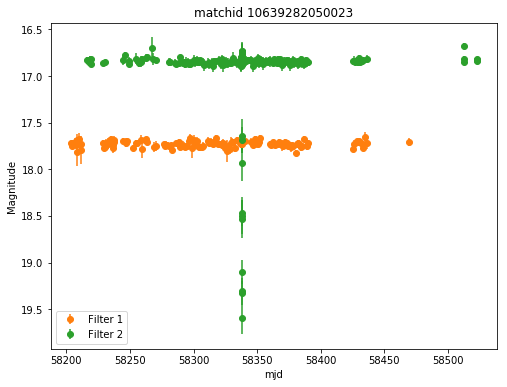

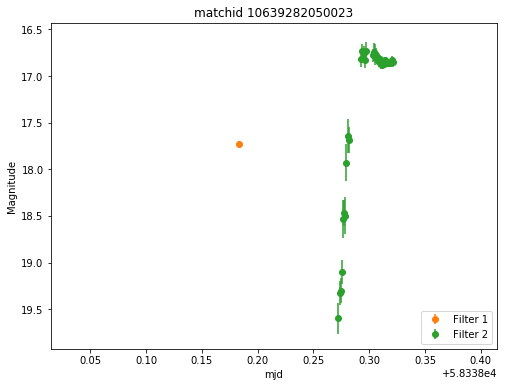

In [9]:
idx = 0
print(detect_dippers_row(ordered_res[idx], verbose=True))
print("ra: %.6f" % ordered_res[idx]['ra'])
print("dec: %.6f" % ordered_res[idx]['dec'])

plot_lightcurve(ordered_res[idx])
plot_lightcurve(ordered_res[idx])

center = 58338.21444
width = 0.2
plt.xlim(center-width, center+width)

Max mjd:  58338.2144444
13.969378315676162
ra: 290.213584
dec: 25.212127


(58338.014440000006, 58338.41444)

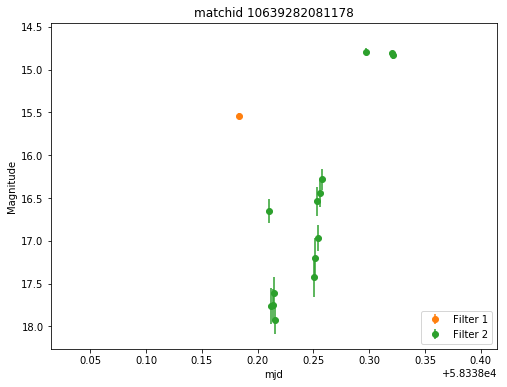

In [10]:
idx = order[1]
print(detect_dippers_row(res[idx], verbose=True))
plot_lightcurve(res[idx])
print("ra: %.6f" % res[idx]['ra'])
print("dec: %.6f" % res[idx]['dec'])
center = 58338.21444
width = 0.2
plt.xlim(center-width, center+width)

# Artifact investigation

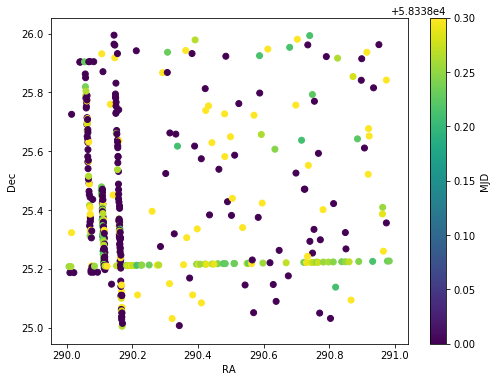

In [13]:
# Hmm, many of our dippers show up in a line on the sky!
ra = [i['ra'] for i in res]
dec = [i['dec'] for i in res]

plt.figure(figsize=(8, 6))
plt.scatter(ra, dec, c = mjds, vmin=58338, vmax=58338.3)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='MJD')

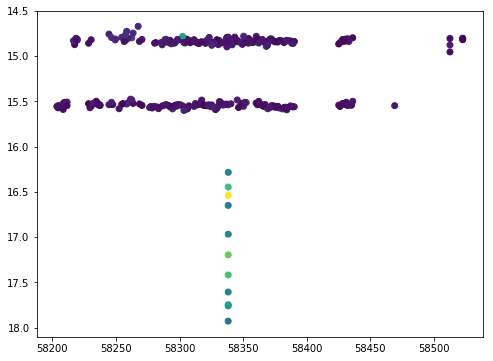

In [12]:
# Dips correspond to bad PSF fits
plt.figure(figsize=(8, 6))
i = res[idx]
plt.scatter(i['mjd'], i['mag'], c=i['chi'])
plt.gca().invert_yaxis()